# Copied from BrA_Separation_merged-reproject on July 28, 2023

In [1]:
from photutils import CircularAperture, EPSFBuilder, find_peaks, CircularAnnulus
from photutils.detection import DAOStarFinder, IRAFStarFinder
from photutils.psf import DAOGroup, IntegratedGaussianPRF, extract_stars, IterativelySubtractedPSFPhotometry, BasicPSFPhotometry

/scratch/local/4075455/ipykernel_56375/2258313207.py:1: DeprecationWarning: `photutils.CircularAperture` is a deprecated alias for `photutils.aperture.CircularAperture` and will be removed in the future. Instead, please use `from photutils.aperture import CircularAperture` to silence this warning.
  from photutils import CircularAperture, EPSFBuilder, find_peaks, CircularAnnulus
/scratch/local/4075455/ipykernel_56375/2258313207.py:1: DeprecationWarning: `photutils.EPSFBuilder` is a deprecated alias for `photutils.psf.EPSFBuilder` and will be removed in the future. Instead, please use `from photutils.psf import EPSFBuilder` to silence this warning.
  from photutils import CircularAperture, EPSFBuilder, find_peaks, CircularAnnulus
/scratch/local/4075455/ipykernel_56375/2258313207.py:1: DeprecationWarning: `photutils.find_peaks` is a deprecated alias for `photutils.detection.find_peaks` and will be removed in the future. Instead, please use `from photutils.detection import find_peaks` to 

In [2]:
from photutils.background import MMMBackground, MADStdBackgroundRMS
from astropy.modeling.fitting import LevMarLSQFitter

In [3]:
from astropy import stats
from astropy.table import Table
from astropy.wcs import WCS

In [4]:
from astropy.io import fits

In [5]:
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.visualization import simple_norm
from astropy import wcs
from astropy import table
from astropy import units as u
import pylab as pl
pl.rcParams['figure.facecolor'] = 'w'
pl.rcParams['image.origin'] = 'lower'

In [6]:
from astroquery.svo_fps import SvoFps

In [7]:
import numpy as np

In [8]:
import reproject

In [9]:
from astropy import units as u

In [10]:
basepath = '/orange/adamginsburg/jwst/brick/'

In [11]:
fh_187 = fits.open(f'{basepath}/F187N/pipeline/jw02221-o001_t001_nircam_clear-f187n-merged-reproject_i2d.fits')
fh_182 = fits.open(f'{basepath}/F182M/pipeline/jw02221-o001_t001_nircam_clear-f182m-merged-reproject_i2d.fits')

In [12]:
ww187 = wcs.WCS(fh_187['SCI'].header)
ww182 = wcs.WCS(fh_182['SCI'].header)

In [15]:
instrument = fh_187[0].header['INSTRUME']
telescope = fh_187[0].header['TELESCOP']
filt187 = fh_187[0].header['FILTER']
wavelength_table_187 = SvoFps.get_transmission_data(f'{telescope}/{instrument}.{filt187}')
filt182 = fh_182[0].header['FILTER']
wavelength_table_182 = SvoFps.get_transmission_data(f'{telescope}/{instrument}.{filt182}')

In [16]:
filt187, filt182

('F187N', 'F182M')

In [17]:
waves_182 = wavelength_table_182['Wavelength']
trans_187 = np.interp(waves_182, wavelength_table_187['Wavelength'], wavelength_table_187['Transmission'])
trans_182 = wavelength_table_182['Transmission']

Text(0.5, 0, 'Wavelength [Angstroms]')

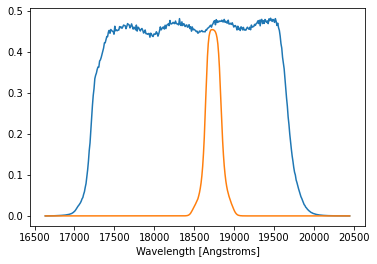

In [18]:
pl.plot(waves_182, trans_182)
pl.plot(waves_182, trans_187)
pl.xlabel("Wavelength [Angstroms]")

In [19]:
fractional_bandwidth_187 = (( (trans_182/trans_182.max()) *
                            (trans_187/trans_187.max()) ).sum()
                            / (trans_182/trans_182.max()).sum()
                           )
fractional_bandwidth_187

0.09655212419159323

In [20]:
fraction_bandwidth_empirical = 0.1742 # see end of document

In [21]:
data_187_proj_182 = reproject.reproject_exact(fh_187['SCI'], fh_182['SCI'].header)

/blue/adamginsburg/adamginsburg/repos/reproject/reproject/spherical_intersect/core.py:47: UserWarning: The reproject_exact function currently has precision issues with images that have resolutions below ~0.05 arcsec, so the results may not be accurate.
  warnings.warn(


In [22]:
from astropy.convolution import convolve_fft, Gaussian2DKernel

### from PSF analysis below, we need to smooth the BrA data with an 0.3 pix gaussian

In [23]:
cont182_sub_paa = fh_182['SCI'].data - convolve_fft(data_187_proj_182[0]*fractional_bandwidth_187, Gaussian2DKernel(0.3))
fits.PrimaryHDU(data=cont182_sub_paa, header=fh_182['SCI'].header).writeto(f'{basepath}/images/F182_minus_F187_merged-reproject_theoretical_bandwidth.fits', overwrite=True)

In [24]:
paa_minus_cont = data_187_proj_182[0] - cont182_sub_paa #* fractional_bandwidth_187
fits.PrimaryHDU(data=paa_minus_cont, header=fh_182['SCI'].header).writeto(f'{basepath}/images/F187_minus_F182cont_merged-reproject_theoretical_bandwidth.fits', overwrite=True)

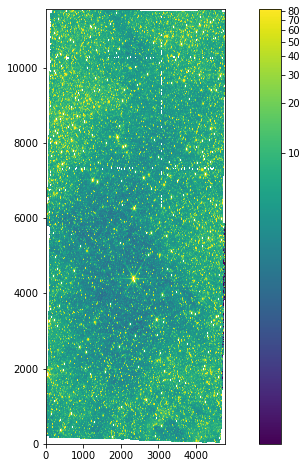

In [25]:
pl.figure(figsize=(12,8))
pl.imshow(fh_182['SCI'].data, norm=simple_norm(cont182_sub_paa, min_percent=1, max_percent=99, stretch='log'))
pl.colorbar()

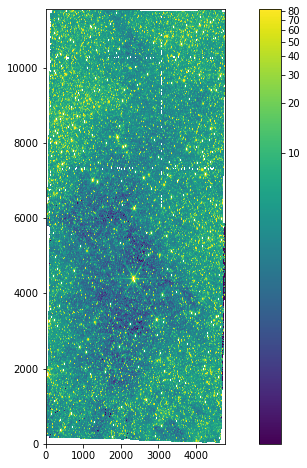

In [26]:
pl.figure(figsize=(12,8))
pl.imshow(cont182_sub_paa, norm=simple_norm(cont182_sub_paa, min_percent=1, max_percent=99, stretch='log'))
pl.colorbar()

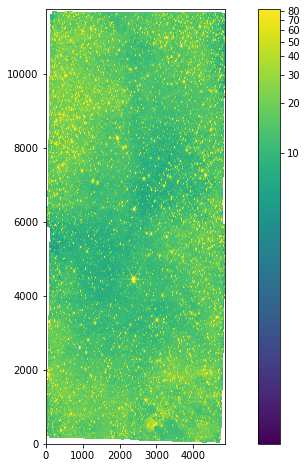

In [27]:
pl.figure(figsize=(12,8))
pl.imshow(fh_187['SCI'].data, norm=simple_norm(cont182_sub_paa, min_percent=1, max_percent=99, stretch='log'))
pl.colorbar()

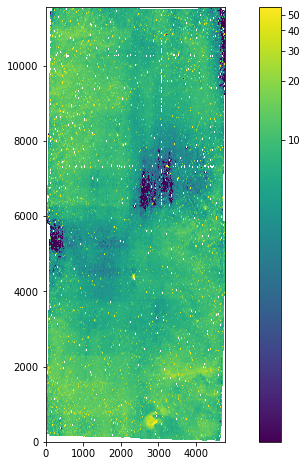

In [28]:
pl.figure(figsize=(12,8))
pl.imshow(paa_minus_cont, norm=simple_norm(paa_minus_cont, min_percent=4, max_percent=99.5, stretch='log'))
pl.colorbar()

# PSF comparison

There was evidence of oversubtraction / undersubtraction in rings around the stars in the 187-182 image before we did PSF convolution:

In [29]:
class slcgt:
    def __getitem__(self, args):
        return args

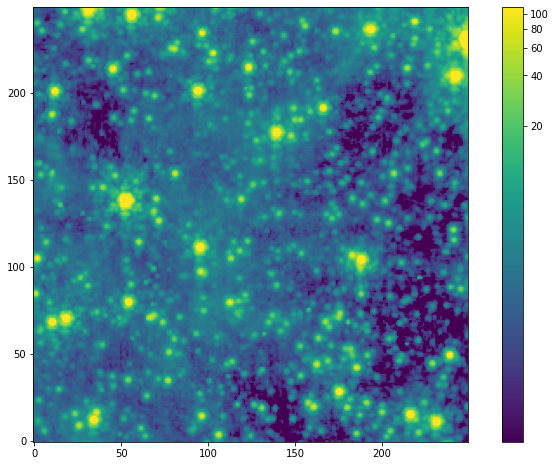

In [30]:
dd = fh_182['SCI'].data
pl.figure(figsize=(12,8))
slc = slcgt()[1000:1250,1000:1250]
pl.imshow(dd[slc],
          norm=simple_norm(dd[slc], min_percent=4, max_percent=99.5, stretch='log'))
pl.colorbar()

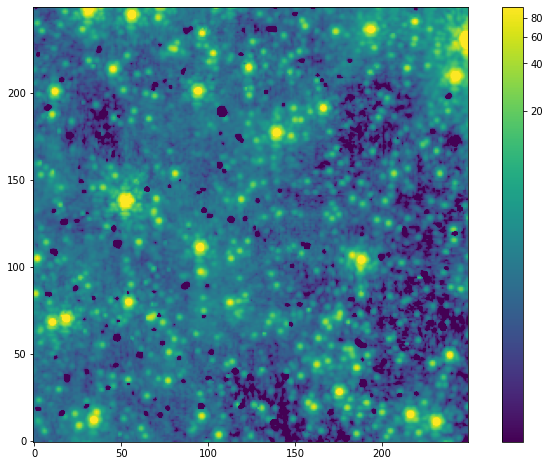

In [31]:
pl.figure(figsize=(12,8))
slc = slcgt()[1000:1250,1000:1250]
pl.imshow(cont182_sub_paa[slc],
          norm=simple_norm(cont182_sub_paa[slc], min_percent=4, max_percent=99.5, stretch='log'))
pl.colorbar()

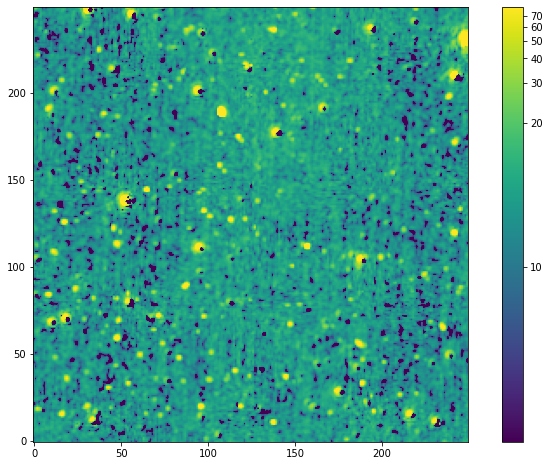

In [32]:
pl.figure(figsize=(12,8))
slc = slcgt()[1000:1250,1000:1250]
pl.imshow(paa_minus_cont[slc],
          norm=simple_norm(paa_minus_cont[slc], min_percent=4, max_percent=99.5, stretch='log'))
pl.colorbar()

In [33]:
import os
os.environ['WEBBPSF_PATH'] = '/orange/adamginsburg/jwst/webbpsf-data/'
import webbpsf
from webbpsf.utils import to_griddedpsfmodel

**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-059 CANNOT BE CHECKED AGAINST ONLINE VERSION


In [34]:
import sys
sys.path.append(f'{basepath}/reduction/')

In [35]:
import saturated_star_finding
import imp
imp.reload(saturated_star_finding)
from saturated_star_finding import get_psf

/orange/adamginsburg/jwst/brick//reduction/filtering.py:20: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
/scratch/local/4075455/ipykernel_56375/3296037540.py:2: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp


In [36]:
psf_paa = get_psf(fh_187['SCI'].header)

Attempting to load PSF for 2022-08-28
INFO: MAST API token accepted, welcome Adam Ginsburg [astroquery.mast.auth]

MAST OPD query around UTC: 2022-08-28T00:00:00.000
                        MJD: 59819.0

OPD immediately preceding the given datetime:
	URI:	 mast:JWST/product/R2022082702-NRCA3_FP1-1.fits
	Date (MJD):	 59817.7488
	Delta time:	 -1.2512 days

OPD immediately following the given datetime:
	URI:	 mast:JWST/product/R2022082902-NRCA3_FP1-1.fits
	Date (MJD):	 59819.7687
	Delta time:	 0.7687 days
User requested choosing OPD time closest in time to 2022-08-28T00:00:00.000, which is R2022082902-NRCA3_FP1-1.fits, delta time 0.769 days
INFO: MAST API token accepted, welcome Adam Ginsburg [astroquery.mast.auth]
Importing and format-converting OPD from /orange/adamginsburg/jwst/webbpsf-data/MAST_JWST_WSS_OPDs/R2022082902-NRCA3_FP1-1.fits
Backing out SI WFE and OTE field dependence at the WF sensing field point
INFO: starfinding: Calculating grid for psf_fn=./nircam_F187N_samp2_nspsf16_

/blue/adamginsburg/adamginsburg/repos/webbpsf/webbpsf/opds.py:1745: UserWarning: For (V2,V3) = [-2.58673975 -9.28552761] arcmin, Field point -2.582628 arcmin, 1.4855276135105395 arcmin not within valid region for field dependence model of OTE WFE for NIRCam: -2.582628 arcmin-2.582628 arcmin, -1.539012 arcmin-1.539012 arcmin. Clipping to closest available valid location, 0.004111745285014123 arcmin away from the requested coordinates.
  warnings.warn(f'For (V2,V3) = {v2v3}, Field point {x_field_pt}, {y_field_pt} not within valid region for field dependence model of OTE WFE for {instrument}: {min_x_field}-{max_x_field}, {min_y_field}-{max_y_field}. Clipping to closest available valid location, {clip_dist} away from the requested coordinates.')


    Position 14/16: (2047, 682) pixels
    Position 15/16: (2047, 1365) pixels
    Position 16/16: (2047, 2047) pixels
  Saving file: ././nircam_F187N_samp2_nspsf16_npix512_nrcb2.fits
  Running detector: NRCB3
    Position 1/16: (0, 0) pixels
    Position 2/16: (0, 682) pixels
    Position 3/16: (0, 1365) pixels
    Position 4/16: (0, 2047) pixels
    Position 5/16: (682, 0) pixels
    Position 6/16: (682, 682) pixels
    Position 7/16: (682, 1365) pixels
    Position 8/16: (682, 2047) pixels
    Position 9/16: (1365, 0) pixels
    Position 10/16: (1365, 682) pixels
    Position 11/16: (1365, 1365) pixels
    Position 12/16: (1365, 2047) pixels
    Position 13/16: (2047, 0) pixels
    Position 14/16: (2047, 682) pixels
    Position 15/16: (2047, 1365) pixels
    Position 16/16: (2047, 2047) pixels
  Saving file: ././nircam_F187N_samp2_nspsf16_npix512_nrcb3.fits
  Running detector: NRCB4
    Position 1/16: (0, 0) pixels
    Position 2/16: (0, 682) pixels
    Position 3/16: (0, 1365) pix

In [37]:
psf_182 = get_psf(fh_182['SCI'].header)

Attempting to load PSF for 2022-08-28
INFO: MAST API token accepted, welcome Adam Ginsburg [astroquery.mast.auth]

MAST OPD query around UTC: 2022-08-28T00:00:00.000
                        MJD: 59819.0

OPD immediately preceding the given datetime:
	URI:	 mast:JWST/product/R2022082702-NRCA3_FP1-1.fits
	Date (MJD):	 59817.7488
	Delta time:	 -1.2512 days

OPD immediately following the given datetime:
	URI:	 mast:JWST/product/R2022082902-NRCA3_FP1-1.fits
	Date (MJD):	 59819.7687
	Delta time:	 0.7687 days
User requested choosing OPD time closest in time to 2022-08-28T00:00:00.000, which is R2022082902-NRCA3_FP1-1.fits, delta time 0.769 days
Importing and format-converting OPD from /orange/adamginsburg/jwst/webbpsf-data/MAST_JWST_WSS_OPDs/R2022082902-NRCA3_FP1-1.fits
Backing out SI WFE and OTE field dependence at the WF sensing field point
INFO: starfinding: Calculating grid for psf_fn=./nircam_F182M_samp2_nspsf16_npix512.fits [saturated_star_finding]

Running instrument: NIRCam, filter: F

/blue/adamginsburg/adamginsburg/repos/webbpsf/webbpsf/opds.py:1745: UserWarning: For (V2,V3) = [-2.58673975 -9.28552761] arcmin, Field point -2.582628 arcmin, 1.4855276135105395 arcmin not within valid region for field dependence model of OTE WFE for NIRCam: -2.582628 arcmin-2.582628 arcmin, -1.539012 arcmin-1.539012 arcmin. Clipping to closest available valid location, 0.004111745285014123 arcmin away from the requested coordinates.
  warnings.warn(f'For (V2,V3) = {v2v3}, Field point {x_field_pt}, {y_field_pt} not within valid region for field dependence model of OTE WFE for {instrument}: {min_x_field}-{max_x_field}, {min_y_field}-{max_y_field}. Clipping to closest available valid location, {clip_dist} away from the requested coordinates.')


    Position 14/16: (2047, 682) pixels
    Position 15/16: (2047, 1365) pixels
    Position 16/16: (2047, 2047) pixels
  Saving file: ././nircam_F182M_samp2_nspsf16_npix512_nrcb2.fits
  Running detector: NRCB3
    Position 1/16: (0, 0) pixels
    Position 2/16: (0, 682) pixels
    Position 3/16: (0, 1365) pixels
    Position 4/16: (0, 2047) pixels
    Position 5/16: (682, 0) pixels
    Position 6/16: (682, 682) pixels
    Position 7/16: (682, 1365) pixels
    Position 8/16: (682, 2047) pixels
    Position 9/16: (1365, 0) pixels
    Position 10/16: (1365, 682) pixels
    Position 11/16: (1365, 1365) pixels
    Position 12/16: (1365, 2047) pixels
    Position 13/16: (2047, 0) pixels
    Position 14/16: (2047, 682) pixels
    Position 15/16: (2047, 1365) pixels
    Position 16/16: (2047, 2047) pixels
  Saving file: ././nircam_F182M_samp2_nspsf16_npix512_nrcb3.fits
  Running detector: NRCB4
    Position 1/16: (0, 0) pixels
    Position 2/16: (0, 682) pixels
    Position 3/16: (0, 1365) pix

In [38]:
from astropy.visualization import imshow_norm, simple_norm, LogStretch, AsinhStretch

(<matplotlib.image.AxesImage at 0x2ad47f5f21c0>,
 <astropy.visualization.mpl_normalize.ImageNormalize at 0x2ad47edb3df0>)

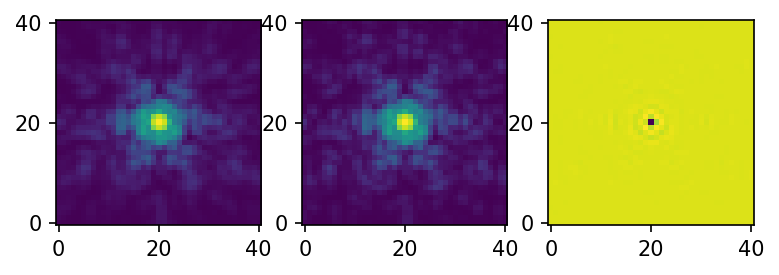

In [39]:
yy, xx = np.mgrid[-20:20.1:1,-20:20.1:1]
pl.figure(dpi=150)
ax = pl.subplot(1,3,1)
imshow_norm(psf_182(xx, yy), ax=ax, stretch=LogStretch())
ax = pl.subplot(1,3,2)
imshow_norm(psf_paa(xx, yy), ax=ax, stretch=LogStretch())
ax = pl.subplot(1,3,3)
imshow_norm(psf_paa(xx, yy) - psf_182(xx, yy), ax=ax, stretch=AsinhStretch())

In [40]:
pb = psf_paa(xx, yy)
p4 = psf_182(xx, yy)
from astropy.convolution import convolve, convolve_fft, Gaussian2DKernel, AiryDisk2DKernel
def residual(x):
    return convolve(pb, Gaussian2DKernel(x)) - p4
def aresidual(x):
    return convolve(pb, AiryDisk2DKernel(x)) - p4

/blue/adamginsburg/adamginsburg/repos/astropy/astropy/convolution/kernels.py:171: RuntimeWarning: divide by zero encountered in double_scalars
  amplitude=1.0 / (2 * np.pi * x_stddev * y_stddev),
/blue/adamginsburg/adamginsburg/repos/astropy/astropy/modeling/functional_models.py:470: RuntimeWarning: divide by zero encountered in divide
  a = 0.5 * ((cost2 / xstd2) + (sint2 / ystd2))
/blue/adamginsburg/adamginsburg/repos/astropy/astropy/modeling/functional_models.py:470: RuntimeWarning: invalid value encountered in divide
  a = 0.5 * ((cost2 / xstd2) + (sint2 / ystd2))
/blue/adamginsburg/adamginsburg/repos/astropy/astropy/modeling/functional_models.py:471: RuntimeWarning: invalid value encountered in divide
  b = 0.5 * ((sin2t / xstd2) - (sin2t / ystd2))
/blue/adamginsburg/adamginsburg/repos/astropy/astropy/modeling/functional_models.py:472: RuntimeWarning: invalid value encountered in divide
  c = 0.5 * ((sint2 / xstd2) + (cost2 / ystd2))
/blue/adamginsburg/adamginsburg/repos/astropy/a

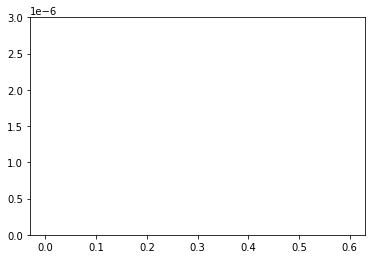

In [41]:
pl.plot(np.linspace(0,0.6), [(residual(x)**2).sum() for x in np.linspace(0,0.6)])
pl.plot(np.linspace(0.1,0.4), [(residual(x)**2).sum() for x in np.linspace(0.1,0.4)])
pl.plot(np.linspace(0,0.6), [(aresidual(x)**2).sum() for x in np.linspace(0,0.6)])
pl.ylim(0,0.000003);

In [42]:
resids = [(residual(x)**2).sum() for x in np.linspace(0.2,0.4)]
np.linspace(0.2,0.4)[np.argmin(resids)]

0.2

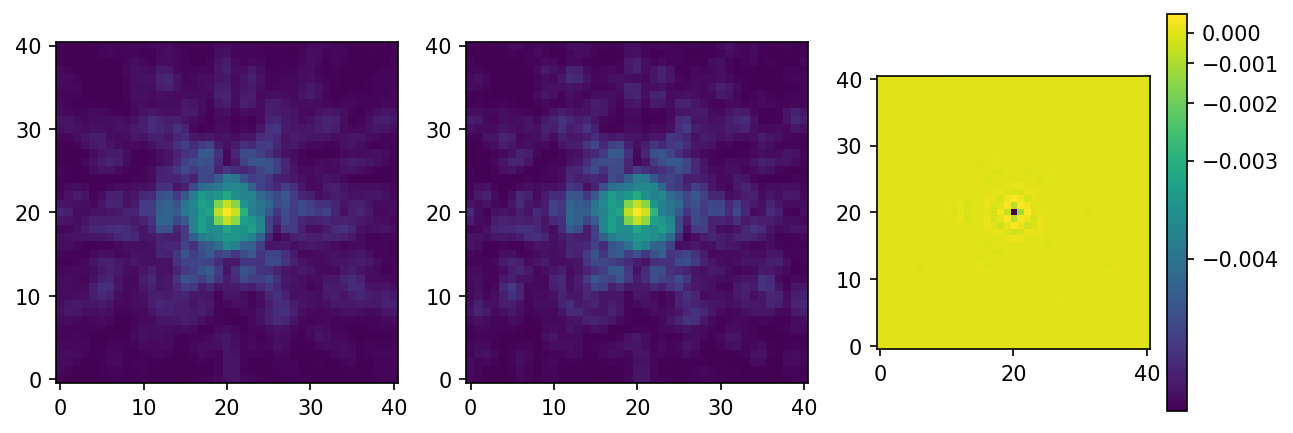

In [43]:
yy, xx = np.mgrid[-20:20.1:1,-20:20.1:1]
pl.figure(dpi=150, figsize=(10,3.5))
ax = pl.subplot(1,3,1)
imshow_norm(psf_182(xx, yy), ax=ax, stretch=LogStretch())
ax = pl.subplot(1,3,2)
imshow_norm(psf_paa(xx, yy), ax=ax, stretch=LogStretch())
ax = pl.subplot(1,3,3)
im, norm = imshow_norm(convolve(psf_paa(xx, yy), Gaussian2DKernel(0.3)) - psf_182(xx, yy), ax=ax, stretch=AsinhStretch())
pl.colorbar(mappable=im)

In [44]:
Gaussian2DKernel(0.3, x_size=xx.shape[1], y_size=yy.shape[0]).array.shape

(41, 41)

### Attempt direct deconvolution

Maybe a Gaussian isn't the right kernel?

In [45]:
ft4 = np.fft.fftshift(np.fft.fft2(psf_182(xx, yy)))
ftb = np.fft.fftshift(np.fft.fft2(psf_paa(xx, yy)))
ftk = np.fft.fftshift(np.fft.fft2(Gaussian2DKernel(0.3, x_size=xx.shape[1], y_size=yy.shape[0]).array))

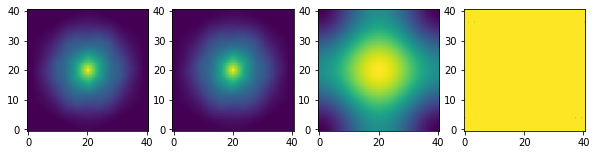

In [46]:
pl.figure(figsize=(10,3))
pl.subplot(1,4,1)
pl.imshow(np.abs(ftb))
pl.subplot(1,4,2)
pl.imshow(np.abs(ft4))
pl.subplot(1,4,3)
pl.imshow(np.abs(ftk))
pl.subplot(1,4,4)
pl.imshow(np.abs(ft4/ftb), vmin=0, vmax=1)

/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


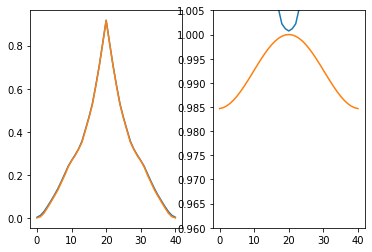

In [47]:
#im, norm = imshow_norm(np.abs(ft4)/np.abs(ftb) * np.abs(ftb) > 1e-3, stretch=AsinhStretch(), vmax=1.1, vmin=0.9)
#pl.colorbar(mappable=im)
pl.subplot(1,2,1)
pl.plot(np.abs((ft4[20,:])))
pl.plot(np.abs((ftb[20,:])))
pl.subplot(1,2,2)
pl.plot(np.abs((ft4[20,:])) / np.abs((ftb[20,:])))
pl.plot(np.abs(ftk[20,:]) / ftk.max())
pl.ylim(0.96, 1.005);

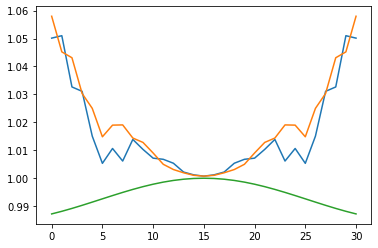

In [48]:
pl.plot((ft4[20,5:-5] / ftb[20,5:-5]))
pl.plot((ft4[5:-5,20] / ftb[5:-5,20]))
pl.plot(np.abs(ftk[5:-5,20])/np.abs(ftk).max())

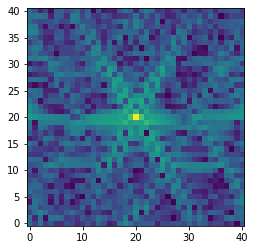

In [49]:
paa_to_182_kernel = np.abs((np.fft.fftshift(np.fft.fft2(ft4/ftb))))
paa_to_182_kernel /= paa_to_182_kernel.max()
imshow_norm(paa_to_182_kernel, stretch=LogStretch())
paa_to_182_kernel.max()
paa_to_182_kernel_ = np.zeros_like(paa_to_182_kernel)
paa_to_182_kernel_[15:25,15:25] = paa_to_182_kernel[15:25, 15:25]
paa_to_182_kernel = paa_to_182_kernel_

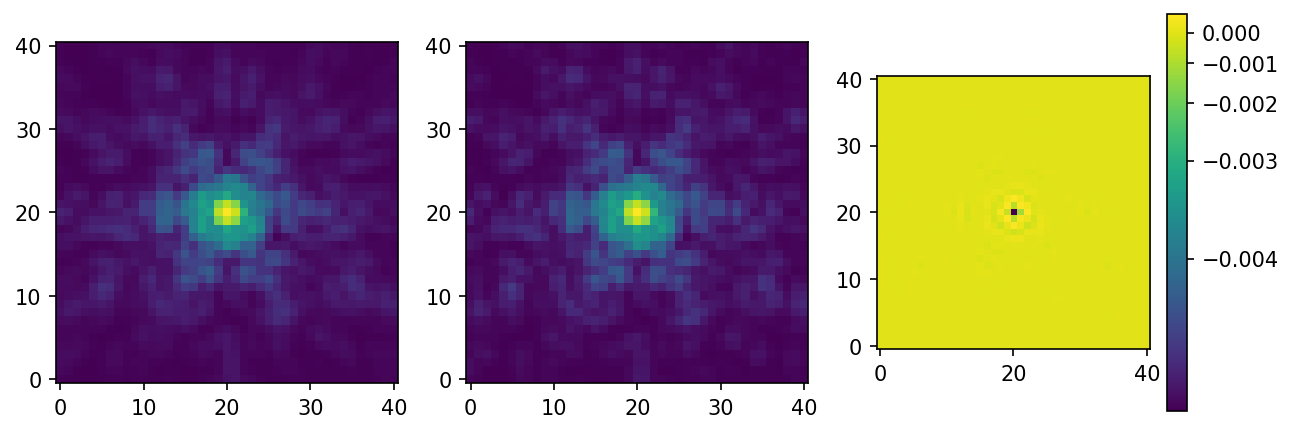

In [50]:
yy, xx = np.mgrid[-20:20.1:1,-20:20.1:1]
pl.figure(dpi=150, figsize=(10,3.5))
ax = pl.subplot(1,3,1)
imshow_norm(psf_182(xx, yy), ax=ax, stretch=LogStretch())
ax = pl.subplot(1,3,2)
imshow_norm(convolve(psf_paa(xx, yy), Gaussian2DKernel(0.3, x_size=41, y_size=41)), ax=ax, stretch=LogStretch())
ax = pl.subplot(1,3,3)
im, norm = imshow_norm(convolve(psf_paa(xx, yy), Gaussian2DKernel(0.3, x_size=41, y_size=41)) - psf_182(xx, yy), ax=ax, stretch=AsinhStretch())
pl.colorbar(mappable=im)

### Kernel

The BrA needs to be convolved with an 0.8469 * 0.1 pixel = 0.085 pixel Gaussian

or an 0.3469 * 0.5 = 0.017 pixel gaussian!?

or an 0.30 pixel gaussian?!

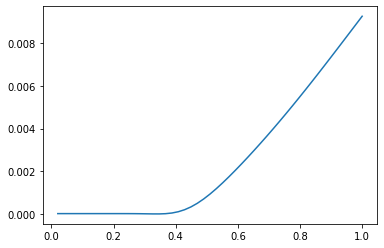

In [51]:
def residual2(x):
    return pb - convolve(p4, Gaussian2DKernel(x))
pl.plot(np.linspace(0,1), [(residual2(x)**2).sum() for x in np.linspace(0,1)])

# Further star removal via photometry

Starfinding on unsubtracted data so we can do some spatial cross-matching.

In [52]:
stars_paa = DAOStarFinder(threshold=60, fwhm=2.302, peakmax=1e4)(fh_187['SCI'].data)
stars_paa['skycoord'] = ww187.pixel_to_world(stars_paa['xcentroid'], stars_paa['ycentroid'])
len(stars_paa)

45101

In [53]:
stars_182 = DAOStarFinder(threshold=10, fwhm=2.302, peakmax=900)(fh_182['SCI'].data)
stars_182['skycoord'] = ww182.pixel_to_world(stars_182['xcentroid'], stars_182['ycentroid'])
len(stars_182)

189465

In [54]:
matches, sep, _ = stars_paa['skycoord'].match_to_catalog_sky(stars_182['skycoord'], nthneighbor=1)

for cn in stars_paa.colnames:
    stars_paa.rename_column(cn, f"{cn}_187")
for cn in stars_182.colnames:
    stars_182.rename_column(cn, f"{cn}_182")
                         
stars_paa.add_column(name="sep_182_187", col=sep)
stars_paa.add_column(name="id_182_187", col=matches)
mergetbl = table.hstack([stars_paa, stars_182[matches]], join_type='exact')

(array([3.5267e+04, 3.4080e+03, 3.8490e+03, 1.4280e+03, 7.0500e+02,
        2.7600e+02, 1.0400e+02, 4.1000e+01, 1.5000e+01, 8.0000e+00]),
 array([6.55950199e-05, 1.04957494e-01, 2.09849392e-01, 3.14741291e-01,
        4.19633189e-01, 5.24525088e-01, 6.29416986e-01, 7.34308885e-01,
        8.39200783e-01, 9.44092682e-01, 1.04898458e+00]),
 <BarContainer object of 10 artists>)

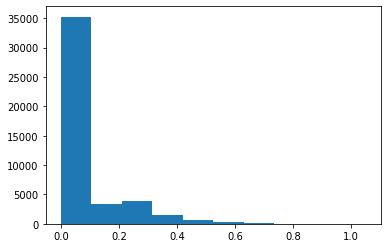

In [55]:
pl.hist(mergetbl['sep_182_187'].to(u.arcsec).value)

(-0.5, 0.5, -0.5, 0.5)

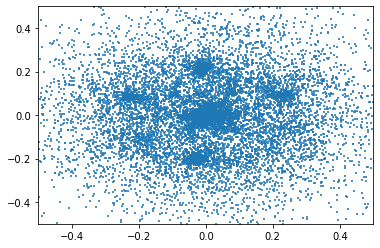

In [56]:
radiff = (mergetbl['skycoord_187'].ra - mergetbl['skycoord_182'].ra).to(u.arcsec)
decdiff = (mergetbl['skycoord_187'].dec - mergetbl['skycoord_182'].dec).to(u.arcsec)
pl.scatter(radiff, decdiff, marker=',', s=1, alpha=0.8)
pl.axis([-0.5,0.5,-0.5,0.5])

# YIKES what the heck - why is there a big blob to the upper right?

Text(0, 0.5, 'Dec offset')

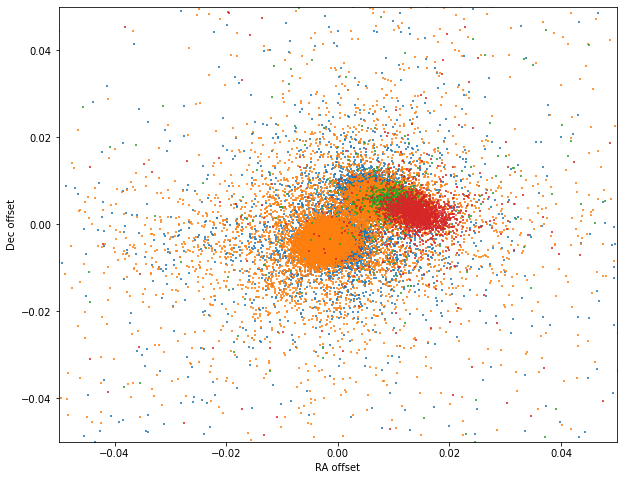

In [57]:
pl.figure(figsize=(10,8))
radiff = (mergetbl['skycoord_187'].ra - mergetbl['skycoord_182'].ra).to(u.arcsec)
decdiff = (mergetbl['skycoord_187'].dec - mergetbl['skycoord_182'].dec).to(u.arcsec)
topleft = (mergetbl['xcentroid_187'] < 1424) & (mergetbl['ycentroid_187'] > 1024)
pl.scatter(radiff[topleft], decdiff[topleft], marker=',', s=1, alpha=0.8)
topright = (mergetbl['xcentroid_187'] > 1424) & (mergetbl['ycentroid_187'] > 1024)
pl.scatter(radiff[topright], decdiff[topright], marker=',', s=1, alpha=0.8)
bottomleft = (mergetbl['xcentroid_187'] < 1424) & (mergetbl['ycentroid_187'] < 1024)
pl.scatter(radiff[bottomleft], decdiff[bottomleft], marker=',', s=1, alpha=0.8)
bottomright = (mergetbl['xcentroid_187'] > 1424) & (mergetbl['ycentroid_187'] < 1024)
pl.scatter(radiff[bottomright], decdiff[bottomright], marker=',', s=1, alpha=0.8)
pl.axis([-0.05,0.05,-0.05,0.05])
pl.xlabel("RA offset")
pl.ylabel("Dec offset")

In [58]:
mergetbl['xcentroid_187'].max(), mergetbl['ycentroid_187'].max()

(4837.605250781148, 11722.131579108933)

In [59]:
dist_from_center = ((mergetbl['xcentroid_187'] - 1450)**2 + (mergetbl['ycentroid_187'] - 1145)**2)**0.5

Text(0, 0.5, 'Offset from F182 (arcseconds)')

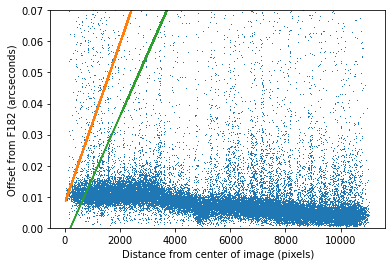

In [60]:
pl.plot(dist_from_center, mergetbl['sep_182_187'].to(u.arcsec).value, ',')
pl.plot(dist_from_center, dist_from_center/1750 * 0.045 + 0.008)
pl.plot(dist_from_center, dist_from_center/1750 * 0.035 - 0.004)
pl.ylim(0,0.07)
pl.xlabel("Distance from center of image (pixels)")
pl.ylabel("Offset from F182 (arcseconds)")

In [61]:
ok = (mergetbl['sep_182_187'] < 0.05*u.arcsec) & (mergetbl['sep_182_187'] < (dist_from_center/1750*0.045 +0.08) *u.arcsec) & (mergetbl['sep_182_187'] > (dist_from_center/1750*0.035 - 0.08) *u.arcsec)

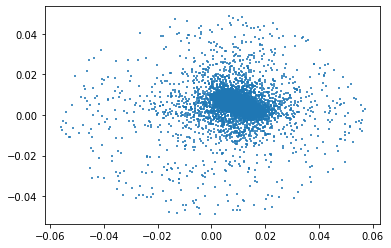

In [62]:
radiff = (mergetbl['skycoord_187'].ra - mergetbl['skycoord_182'].ra).to(u.arcsec)
decdiff = (mergetbl['skycoord_187'].dec - mergetbl['skycoord_182'].dec).to(u.arcsec)
pl.scatter(radiff[ok], decdiff[ok], marker=',', s=1, alpha=0.8)

In [63]:
from astropy.wcs.utils import fit_wcs_from_points

In [64]:
ww_187_refit = fit_wcs_from_points([mergetbl['xcentroid_187'][ok], mergetbl['ycentroid_187'][ok]], mergetbl['skycoord_182'][ok], sip_degree=1)

In [65]:
ww_182_refit = fit_wcs_from_points([mergetbl['xcentroid_182'][ok], mergetbl['ycentroid_182'][ok]], mergetbl['skycoord_187'][ok], sip_degree=3)

In [66]:
skycoord_182_refit = ww_182_refit.pixel_to_world(mergetbl['xcentroid_182'], mergetbl['ycentroid_182'])

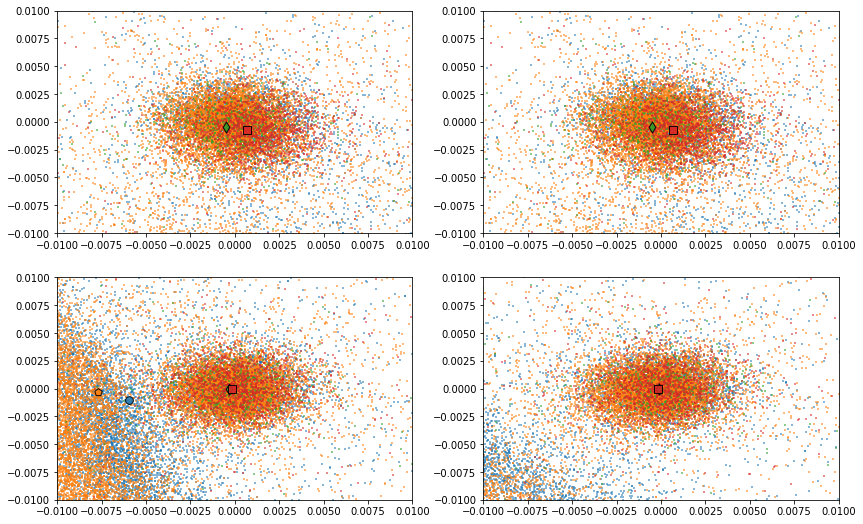

In [67]:
pl.figure(figsize=(14,9))
for sip_degree in (0,1,2,3):
    pl.subplot(2,2,sip_degree+1)
    
    ww_182_refit = fit_wcs_from_points([mergetbl['xcentroid_182'][ok], mergetbl['ycentroid_182'][ok]], mergetbl['skycoord_187'][ok], sip_degree=sip_degree)
    skycoord_182_refit = ww_182_refit.pixel_to_world(mergetbl['xcentroid_182'], mergetbl['ycentroid_182'])
    radiff = (mergetbl['skycoord_187'].ra - skycoord_182_refit.ra).to(u.arcsec)
    decdiff = (mergetbl['skycoord_187'].dec - skycoord_182_refit.dec).to(u.arcsec)
    sep = (radiff**2 + decdiff**2)**0.5
    ww_182_refit = fit_wcs_from_points([mergetbl['xcentroid_182'][ok & (sep < 0.01*u.arcsec)], mergetbl['ycentroid_182'][ok & (sep < 0.01*u.arcsec)]], mergetbl['skycoord_187'][ok & (sep < 0.01*u.arcsec)], sip_degree=sip_degree)
    skycoord_182_refit = ww_182_refit.pixel_to_world(mergetbl['xcentroid_182'], mergetbl['ycentroid_182'])
    radiff = (mergetbl['skycoord_187'].ra - skycoord_182_refit.ra).to(u.arcsec)
    decdiff = (mergetbl['skycoord_187'].dec - skycoord_182_refit.dec).to(u.arcsec)
    sep = (radiff**2 + decdiff**2)**0.5
    
    topleft = (mergetbl['xcentroid_187'] < 1424) & (mergetbl['ycentroid_187'] > 1024)
    sc = pl.scatter(radiff[topleft], decdiff[topleft], marker=',', s=1, alpha=0.5)
    pl.scatter(np.median(radiff[topleft]), np.median(decdiff[topleft]), marker='o', alpha=0.9, c=sc.get_facecolors(), zorder=15, edgecolors='k', s=60)
    topright = (mergetbl['xcentroid_187'] > 1424) & (mergetbl['ycentroid_187'] > 1024)
    sc = pl.scatter(radiff[topright], decdiff[topright], marker=',', s=1, alpha=0.5)
    pl.scatter(np.median(radiff[topright]), np.median(decdiff[topright]), marker='p', alpha=0.9, c=sc.get_facecolors(), zorder=15, edgecolors='k', s=60)
    bottomleft = (mergetbl['xcentroid_187'] < 1424) & (mergetbl['ycentroid_187'] < 1024)
    sc = pl.scatter(radiff[bottomleft], decdiff[bottomleft], marker=',', s=1, alpha=0.5)
    pl.scatter(np.median(radiff[bottomleft]), np.median(decdiff[bottomleft]), marker='d', alpha=0.9, c=sc.get_facecolors(), zorder=15, edgecolors='k', s=60)
    bottomright = (mergetbl['xcentroid_187'] > 1424) & (mergetbl['ycentroid_187'] < 1024)
    sc = pl.scatter(radiff[bottomright], decdiff[bottomright], marker=',', s=1, alpha=0.5)
    pl.scatter(np.median(radiff[bottomright]), np.median(decdiff[bottomright]), marker='s', alpha=0.9, c=sc.get_facecolors(), zorder=25, edgecolors='k', s=60)
    pl.axis([-0.01,0.01,-0.01,0.01])

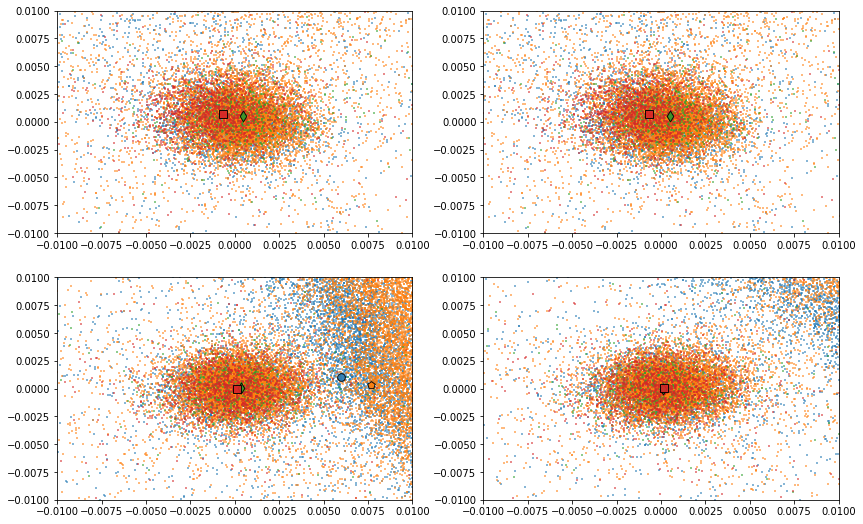

In [68]:
pl.figure(figsize=(14,9))
for sip_degree in (0,1,2,3):
    pl.subplot(2,2,sip_degree+1)
    
    ww_187_refit = fit_wcs_from_points([mergetbl['xcentroid_187'][ok], mergetbl['ycentroid_187'][ok]], mergetbl['skycoord_182'][ok], sip_degree=sip_degree)
    skycoord_187_refit = ww_187_refit.pixel_to_world(mergetbl['xcentroid_187'], mergetbl['ycentroid_187'])
    radiff = (mergetbl['skycoord_182'].ra - skycoord_187_refit.ra).to(u.arcsec)
    decdiff = (mergetbl['skycoord_182'].dec - skycoord_187_refit.dec).to(u.arcsec)
    sep = (radiff**2 + decdiff**2)**0.5
    ww_187_refit = fit_wcs_from_points([mergetbl['xcentroid_187'][ok & (sep < 0.01*u.arcsec)], mergetbl['ycentroid_187'][ok & (sep < 0.01*u.arcsec)]], mergetbl['skycoord_182'][ok & (sep < 0.01*u.arcsec)], sip_degree=sip_degree)
    skycoord_187_refit = ww_187_refit.pixel_to_world(mergetbl['xcentroid_187'], mergetbl['ycentroid_187'])
    radiff = (mergetbl['skycoord_182'].ra - skycoord_187_refit.ra).to(u.arcsec)
    decdiff = (mergetbl['skycoord_182'].dec - skycoord_187_refit.dec).to(u.arcsec)
    sep = (radiff**2 + decdiff**2)**0.5
    
    topleft = (mergetbl['xcentroid_187'] < 1424) & (mergetbl['ycentroid_187'] > 1024)
    sc = pl.scatter(radiff[topleft], decdiff[topleft], marker=',', s=1, alpha=0.5)
    pl.scatter(np.median(radiff[topleft]), np.median(decdiff[topleft]), marker='o', alpha=0.9, c=sc.get_facecolors(), zorder=15, edgecolors='k', s=60)
    topright = (mergetbl['xcentroid_187'] > 1424) & (mergetbl['ycentroid_187'] > 1024)
    sc = pl.scatter(radiff[topright], decdiff[topright], marker=',', s=1, alpha=0.5)
    pl.scatter(np.median(radiff[topright]), np.median(decdiff[topright]), marker='p', alpha=0.9, c=sc.get_facecolors(), zorder=15, edgecolors='k', s=60)
    bottomleft = (mergetbl['xcentroid_187'] < 1424) & (mergetbl['ycentroid_187'] < 1024)
    sc = pl.scatter(radiff[bottomleft], decdiff[bottomleft], marker=',', s=1, alpha=0.5)
    pl.scatter(np.median(radiff[bottomleft]), np.median(decdiff[bottomleft]), marker='d', alpha=0.9, c=sc.get_facecolors(), zorder=15, edgecolors='k', s=60)
    bottomright = (mergetbl['xcentroid_187'] > 1424) & (mergetbl['ycentroid_187'] < 1024)
    sc = pl.scatter(radiff[bottomright], decdiff[bottomright], marker=',', s=1, alpha=0.5)
    pl.scatter(np.median(radiff[bottomright]), np.median(decdiff[bottomright]), marker='s', alpha=0.9, c=sc.get_facecolors(), zorder=25, edgecolors='k', s=60)
    pl.axis([-0.01,0.01,-0.01,0.01])

In [69]:
sip_degree = 3
ww_187_refit = fit_wcs_from_points([mergetbl['xcentroid_187'][ok], mergetbl['ycentroid_187'][ok]], mergetbl['skycoord_182'][ok], sip_degree=sip_degree)
skycoord_187_refit = ww_187_refit.pixel_to_world(mergetbl['xcentroid_187'], mergetbl['ycentroid_187'])
radiff = (mergetbl['skycoord_182'].ra - skycoord_187_refit.ra).to(u.arcsec)
decdiff = (mergetbl['skycoord_182'].dec - skycoord_187_refit.dec).to(u.arcsec)
sep = (radiff**2 + decdiff**2)**0.5
ww_187_refit = fit_wcs_from_points([mergetbl['xcentroid_187'][ok & (sep < 0.01*u.arcsec)], mergetbl['ycentroid_187'][ok & (sep < 0.01*u.arcsec)]], mergetbl['skycoord_182'][ok & (sep < 0.01*u.arcsec)], sip_degree=sip_degree)
skycoord_187_refit = ww_187_refit.pixel_to_world(mergetbl['xcentroid_187'], mergetbl['ycentroid_187'])
radiff = (mergetbl['skycoord_182'].ra - skycoord_187_refit.ra).to(u.arcsec)
decdiff = (mergetbl['skycoord_182'].dec - skycoord_187_refit.dec).to(u.arcsec)
sep = (radiff**2 + decdiff**2)**0.5


In [70]:
ww_187_refit.to_header(relax=True).totextfile(f'{basepath}/reduction/headers/f187n_merged-reproject_refitted_to_f182m.hdr', overwrite=True)

In [71]:
data_187_proj_182_refit, overlap_refit = reproject.reproject_exact((fh_187['SCI'].data, ww_187_refit), fh_182['SCI'].header)

/blue/adamginsburg/adamginsburg/repos/reproject/reproject/spherical_intersect/core.py:47: UserWarning: The reproject_exact function currently has precision issues with images that have resolutions below ~0.05 arcsec, so the results may not be accurate.
  warnings.warn(


In [72]:
fits.PrimaryHDU(data=data_187_proj_182_refit, header=fh_182['SCI'].header).writeto(f'{basepath}/images/F187_refitted187wcsto182_merged-reproject.fits', overwrite=True)

In [73]:
cont182_sub_paa = fh_182['SCI'].data - data_187_proj_182_refit*fractional_bandwidth_187
fits.PrimaryHDU(data=cont182_sub_paa, header=fh_182['SCI'].header).writeto(f'{basepath}/images/F182_minus_F187_refitted187wcsto182_merged-reproject.fits', overwrite=True)

In [74]:
paa_minus_cont = data_187_proj_182_refit - cont182_sub_paa #* fractional_bandwidth_187
fits.PrimaryHDU(data=paa_minus_cont, header=fh_182['SCI'].header).writeto(f'{basepath}/images/F187_minus_F182cont_refitted187wcsto182_merged-reproject.fits', overwrite=True)

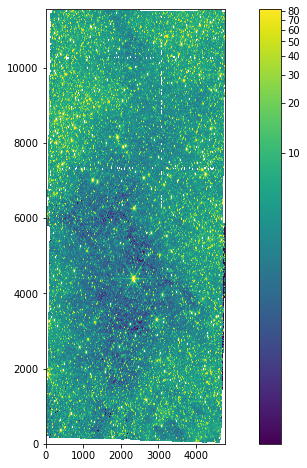

In [75]:
pl.figure(figsize=(12,8))
pl.imshow(cont182_sub_paa, norm=simple_norm(cont182_sub_paa, min_percent=1, max_percent=99, stretch='log'))
pl.colorbar()

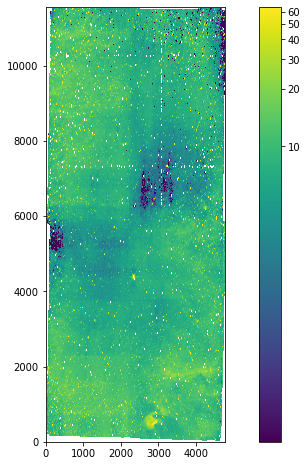

In [76]:
pl.figure(figsize=(12,8))
pl.imshow(paa_minus_cont, norm=simple_norm(paa_minus_cont, min_percent=4, max_percent=99.5, stretch='log'))
pl.colorbar()

In [77]:
latest_scalefactor = np.median(1/(mergetbl['flux_182'][ok]/mergetbl['flux_187'][ok]))
latest_scalefactor

0.1880052491273178

# Goal is to remove stars as completely as possible
we are not trying to measure H-alpha excess here but remove the stars entirely from the image to reveal the extended emission

if we were trying instead to measure stellar halpha excess, we'd want to stick to theory and/or match on something else (maybe extended emission)

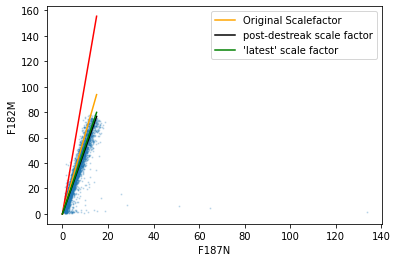

In [78]:
xr = np.linspace(0,15)
pl.scatter(mergetbl['flux_187'][ok], mergetbl['flux_182'][ok], s=1, alpha=0.2)
pl.plot(xr, xr/fractional_bandwidth_187, color='red')
scalefactor = 0.16
pl.plot(xr, xr/scalefactor, color='orange', label="Original Scalefactor")
post_destreak_scalefactor = 0.196
pl.plot(xr, xr/post_destreak_scalefactor, color='black', label="post-destreak scale factor")
pl.plot(xr, xr/latest_scalefactor, color='green', label="'latest' scale factor")
pl.legend(loc='best')
pl.xlabel("F187N")
pl.ylabel("F182M");

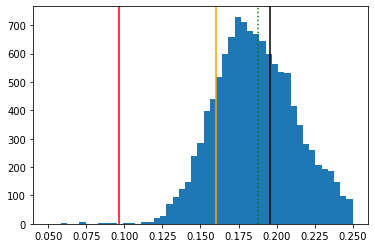

In [79]:
pl.hist(1/(mergetbl['flux_182'][ok]/mergetbl['flux_187'][ok]), bins=np.linspace(0.05,0.25))
pl.axvline(scalefactor, color='orange')
pl.axvline(post_destreak_scalefactor, color='black')
pl.axvline(fractional_bandwidth_187, color='red')
pl.axvline(latest_scalefactor, color='green', linestyle=':')

In [ ]:
cont182_sub_paa = fh_182['SCI'].data - convolve_fft(data_187_proj_182_refit*latest_scalefactor, Gaussian2DKernel(0.3))
fits.PrimaryHDU(data=cont182_sub_paa, header=fh_182['SCI'].header).writeto(f'{basepath}/images/F182_minus_F187_refitted187wcsto182_merged-reproject.fits', overwrite=True)

In [ ]:
paa_minus_cont = data_187_proj_182_refit - cont182_sub_paa#convolve_fft(cont182_sub_paa, Gaussian2DKernel(0.5)) #* fractional_bandwidth_187
fits.PrimaryHDU(data=paa_minus_cont, header=fh_182['SCI'].header).writeto(f'{basepath}/images/F187_minus_F182cont_refitted187wcsto182_merged-reproject.fits', overwrite=True)

Re-examine the images afer the empirical subtraction

In [ ]:
pl.figure(figsize=(12,8))
slc = slcgt()[1000:1250,1000:1250]
pl.imshow(paa_minus_cont[slc],
          norm=simple_norm(paa_minus_cont[slc], min_percent=4, max_percent=99.5, stretch='log'))
pl.colorbar()

In [ ]:
pl.figure(figsize=(12,8))
slc = slcgt()[1000:1250,1000:1250]
pl.imshow(cont182_sub_paa[slc],
          norm=simple_norm(cont182_sub_paa[slc], min_percent=4, max_percent=99.5, stretch='log'))
pl.colorbar()

In [ ]:
pl.figure(figsize=(12,8))
slc = slcgt()[1000:1250,1000:1250]
pl.imshow(fh_182['SCI'].data [slc],
          norm=simple_norm(fh_182['SCI'].data [slc], min_percent=4, max_percent=99.5, stretch='log'))
pl.colorbar()

In [ ]:
pl.figure(figsize=(12,8))
slc = slcgt()[1000:1250,1000:1250]
pl.imshow(data_187_proj_182_refit[slc],
          norm=simple_norm(data_187_proj_182_refit[slc], min_percent=4, max_percent=99.5, stretch='log'))
pl.colorbar()

# Try to find the right scaling factor for the stars

The above scaling factor assumed that the stellar flux in the BrA band matches that in the F182M band, which is only true if most stars do not have BrA absorption.

In [ ]:
pl.scatter(fh_182['SCI'].data, data_187_proj_182_refit, s=1, alpha=0.005)
pl.plot([0,1000], [0,1000], color='k')
pl.plot([0,1000], [0,1000*fractional_bandwidth_187], color='r')
pl.axis([0,200,0,200]);
pl.title("If the data should lay on the 1:1 line, then 100% of emission is BrA");

In [ ]:
pl.hist((data_187_proj_182_refit / fh_182['SCI'].data)[(fh_182['SCI'].data < 200) & (data_187_proj_182_refit < 100)],
        bins=np.linspace(0.1,2));
pl.title("The peak at 1.5x indicates that a large fraction of pixels are starry")